In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
import numpy as np
from itertools import tee
from gui.user_code import pairwise_randomised_significance, get_data_for_signif_test, pairwise_significance_exp_ids
from gui.output_utils import get_cv_fold_count, get_cv_scores_many_experiment
from gui.constants import CLASSIFIER
from discoutils.collections_utils import walk_overlapping_pairs

sns.timeseries.algo.bootstrap = my_bootstrap
sns.categorical.bootstrap = my_bootstrap

/Users/miroslavbatchkarov/NetBeansProjects/ExpLosion


# Does the classification evaluation framework work?
What is the effect of adding uniform random noise to vectors? Can our experiments tell between a set of vectors and a corrupted version of the same vectors? To find out, add uniform random noise from $-n$ to $n$ (x axis) to all non-zero entries in a set of `word2vec` embeddings.
     

In [5]:
def plot(d):
    experiments = Experiment.objects.filter(**d).order_by('expansions__noise')
    e = [x.id for x in experiments if x.expansions.entries_of is None]
    print('experiments are', e)

    for eid in e:
        print('id %d noise %2.2f, acc %2.2f, macrof1 %2.2f'%(eid,
                                              Experiment.objects.get(id=eid).expansions.noise,
                                              Results.objects.get(id=eid, classifier=CLASSIFIER).accuracy_mean,
                                              Results.objects.get(id=eid, classifier=CLASSIFIER).macrof1_mean))

    df = dataframe_from_exp_ids(e, {'Noise':'expansions__noise'})
    df['Noise'] = ['%1.1f'%float(x) for x in df.Noise]
    ax = sns.tsplot(df, time='Noise', value='Accuracy', unit='folds', marker='o')

    # random baseline for comparison
    plt.axhline(random_vect_baseline(corpus=d['labelled']), c='k')
    
    significance_df = pairwise_significance_exp_ids(walk_overlapping_pairs(e), ['expansions__noise'])
    return significance_df

experiments are [34, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]
id 34 noise 0.00, acc 0.53, macrof1 0.49
id 87 noise 0.20, acc 0.53, macrof1 0.49
id 88 noise 0.40, acc 0.50, macrof1 0.45
id 89 noise 0.60, acc 0.44, macrof1 0.41
id 90 noise 0.80, acc 0.39, macrof1 0.34
id 91 noise 1.00, acc 0.34, macrof1 0.31
id 92 noise 1.20, acc 0.31, macrof1 0.28
id 93 noise 1.40, acc 0.28, macrof1 0.25
id 94 noise 1.60, acc 0.27, macrof1 0.24
id 95 noise 1.80, acc 0.26, macrof1 0.22
id 96 noise 2.00, acc 0.25, macrof1 0.21
Accuracy has 5500 values
folds has 5500 values
Noise has 5500 values


/Users/miroslavbatchkarov/anaconda/envs/py3k/lib/python3.3/site-packages/matplotlib/backends/backend_pdf.py:2184: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  different = bool(ours != theirs)

./gui/user_code.py:109: JobLibCollisionWarning: Possible name collisions between functions 'pairwise_randomised_significance' (./gui/user_code.py:-1) and 'pairwise_randomised_significance' (./gui/user_code.py:204)
  get_data_for_signif_test(b))

  get_data_for_signif_test(b))

  different = bool(ours != theirs)



Running significance for (87, 88)
Running significance for (34, 87)
Running significance for (89, 90)
Running significance for (88, 89)
Running significance forRunning significance forRunning significance forRunning significance for (91, 92)
 (90, 91)
 (93, 94)
 (92, 93)
Running significance forRunning significance for (95, 96)
 (94, 95)


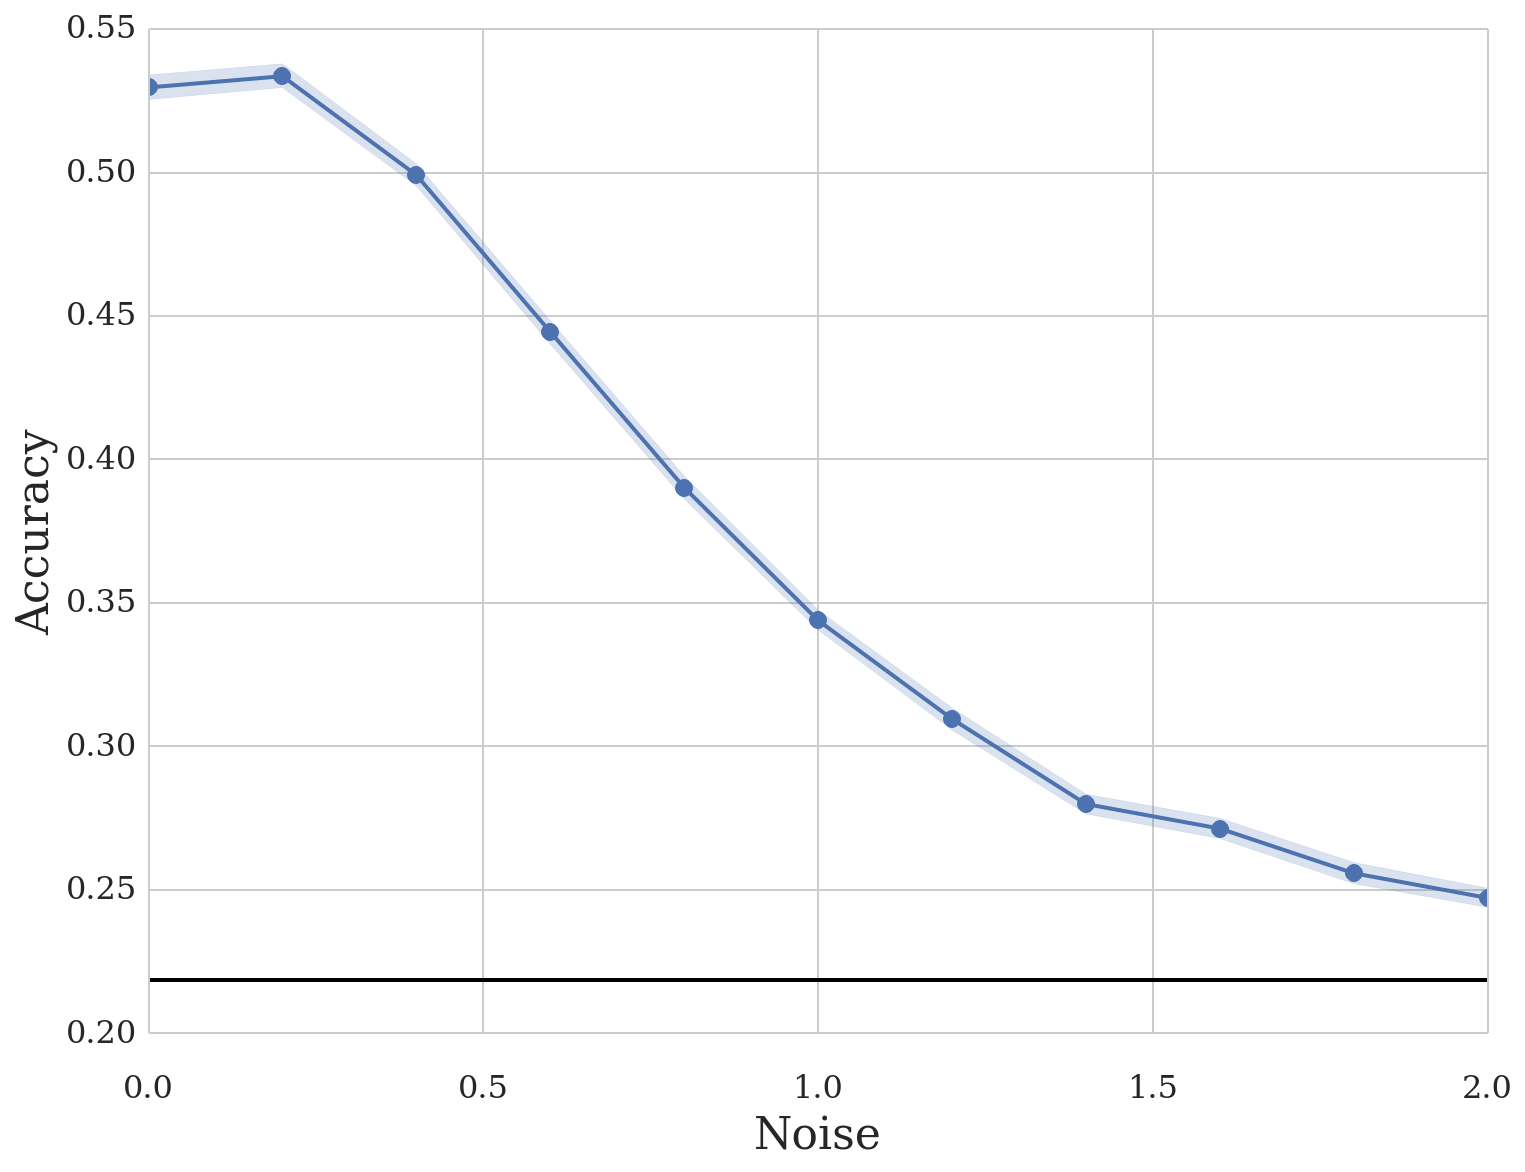

In [6]:
d = {'expansions__vectors__unlabelled_percentage': 100,
     'labelled': 'amazon_grouped-tagged',
     'expansions__vectors__dimensionality': 100,
     'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
     'expansions__vectors__composer': 'Add',
     'expansions__vectors__rep': 0, 
     'expansions__allow_overlap': False,
     'expansions__k': 3,
     'expansions__vectors__unlabelled': 'wiki',
     'expansions__vectors__algorithm': 'word2vec',
     'document_features_tr': 'J+N+AN+NN',
     'document_features_ev': 'AN+NN',
     'labelled': 'amazon_grouped-tagged'}
df = plot(d).convert_objects(convert_numeric=True)
plt.savefig('plot-noise-gigaword-add-amazon.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Question
In thesis `v0.13` this graph didn't look right (Figure 8). 

experiments are [135, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178]
id 135 noise 0.00, acc 0.68, macrof1 0.67
id 169 noise 0.20, acc 0.56, macrof1 0.48
id 170 noise 0.40, acc 0.54, macrof1 0.46
id 171 noise 0.60, acc 0.62, macrof1 0.58
id 172 noise 0.80, acc 0.54, macrof1 0.46
id 173 noise 1.00, acc 0.49, macrof1 0.37
id 174 noise 1.20, acc 0.51, macrof1 0.41
id 175 noise 1.40, acc 0.50, macrof1 0.39
id 176 noise 1.60, acc 0.49, macrof1 0.37
id 177 noise 1.80, acc 0.51, macrof1 0.41
id 178 noise 2.00, acc 0.51, macrof1 0.40
Accuracy has 5500 values
folds has 5500 values
Noise has 5500 values
Calculating CI for exp 169
Calculating CI for exp 171
Calculating CI for exp 170
Calculating CI for exp 135
Calculating CI for exp 173
Calculating CI for exp 175
Calculating CI for exp 174
Calculating CI for exp 172
Calculating CI for exp 177
Calculating CI for exp 178
Calculating CI for exp 176
Running significance for (135, 169)
Running significance for (169, 170)
Running significance for (17

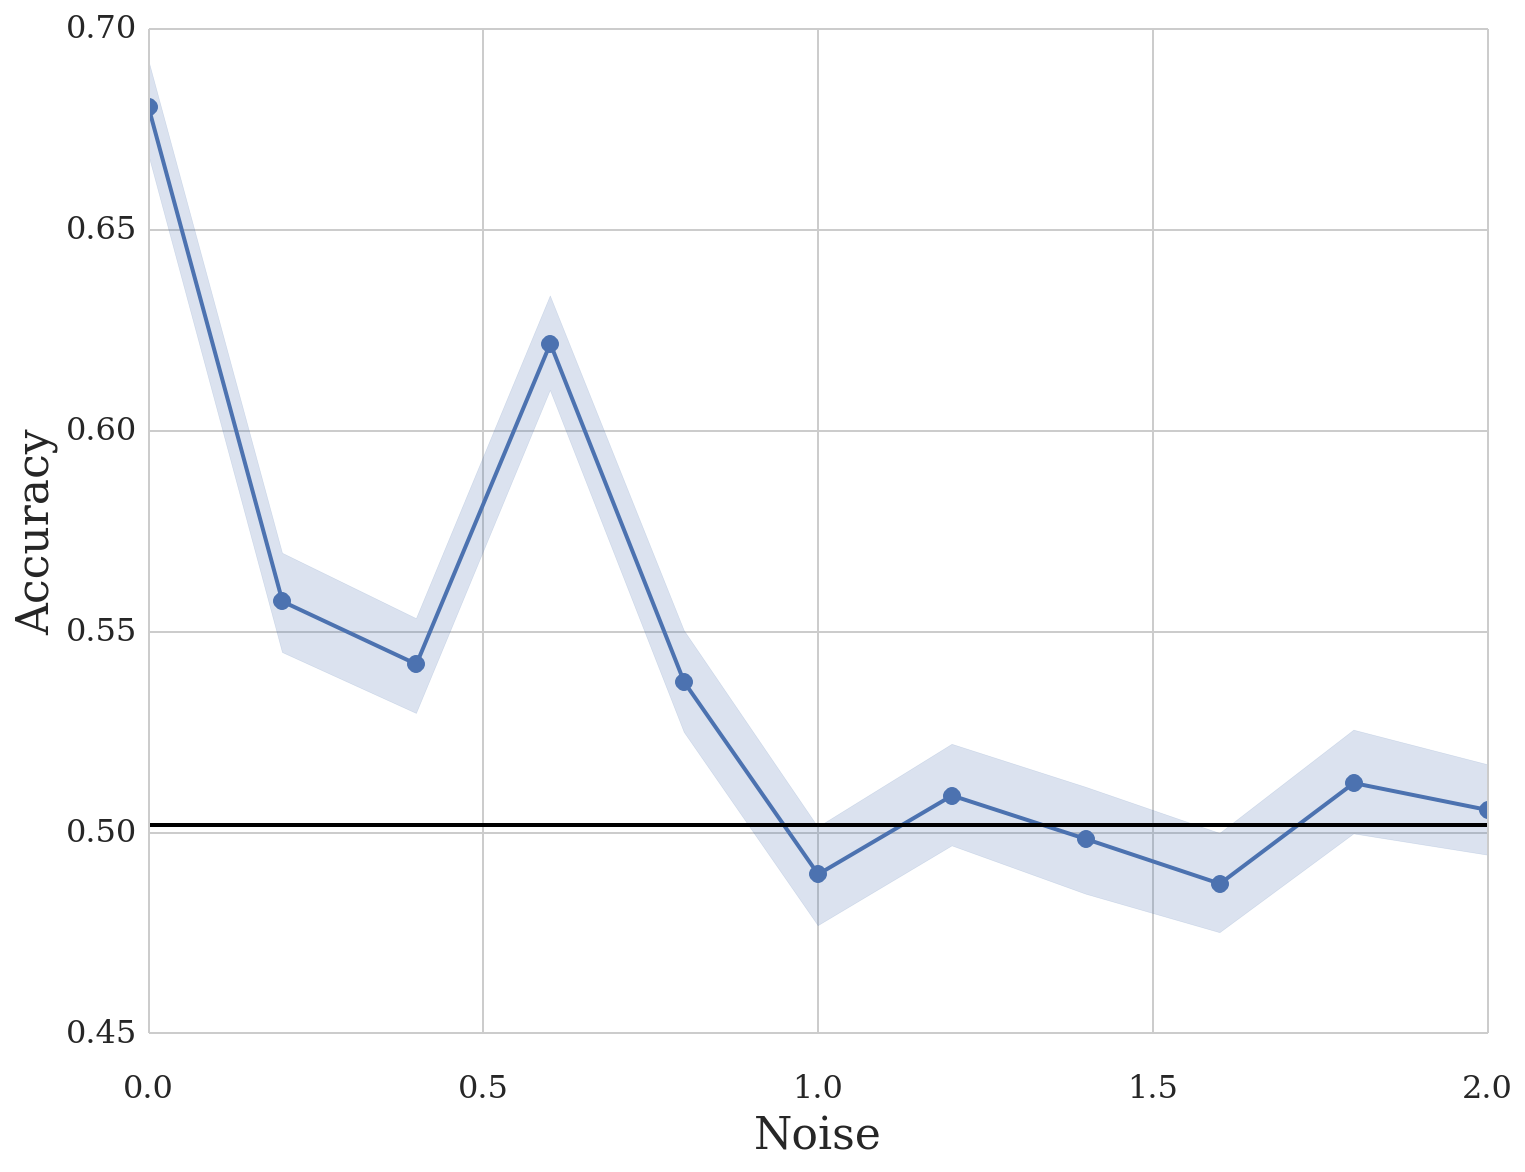

In [7]:
d['labelled'] = 'reuters21578/r8-tagged-grouped'
df2 = plot(d).convert_objects(convert_numeric=True)
plt.savefig('plot-noise-gigaword-add-r2.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

experiments are [392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402]
id 392 noise 0.00, acc 0.59, macrof1 0.52
id 393 noise 0.20, acc 0.55, macrof1 0.46
id 394 noise 0.40, acc 0.53, macrof1 0.43
id 395 noise 0.60, acc 0.50, macrof1 0.36
id 396 noise 0.80, acc 0.49, macrof1 0.34
id 397 noise 1.00, acc 0.49, macrof1 0.33
id 398 noise 1.20, acc 0.49, macrof1 0.33
id 399 noise 1.40, acc 0.49, macrof1 0.33
id 400 noise 1.60, acc 0.49, macrof1 0.33
id 401 noise 1.80, acc 0.49, macrof1 0.33
id 402 noise 2.00, acc 0.49, macrof1 0.33
Accuracy has 5500 values
folds has 5500 values
Noise has 5500 values
Calculating CI for exp 392
Calculating CI for exp 393
Calculating CI for exp 395
Calculating CI for exp 394
Calculating CI for exp 397
Calculating CI for exp 398
Calculating CI for exp 396
Calculating CI for exp 399
Calculating CI for exp 401
Calculating CI for exp 402
Calculating CI for exp 400
Running significance for (392, 393)
Running significance for (393, 394)
Running significance for (39

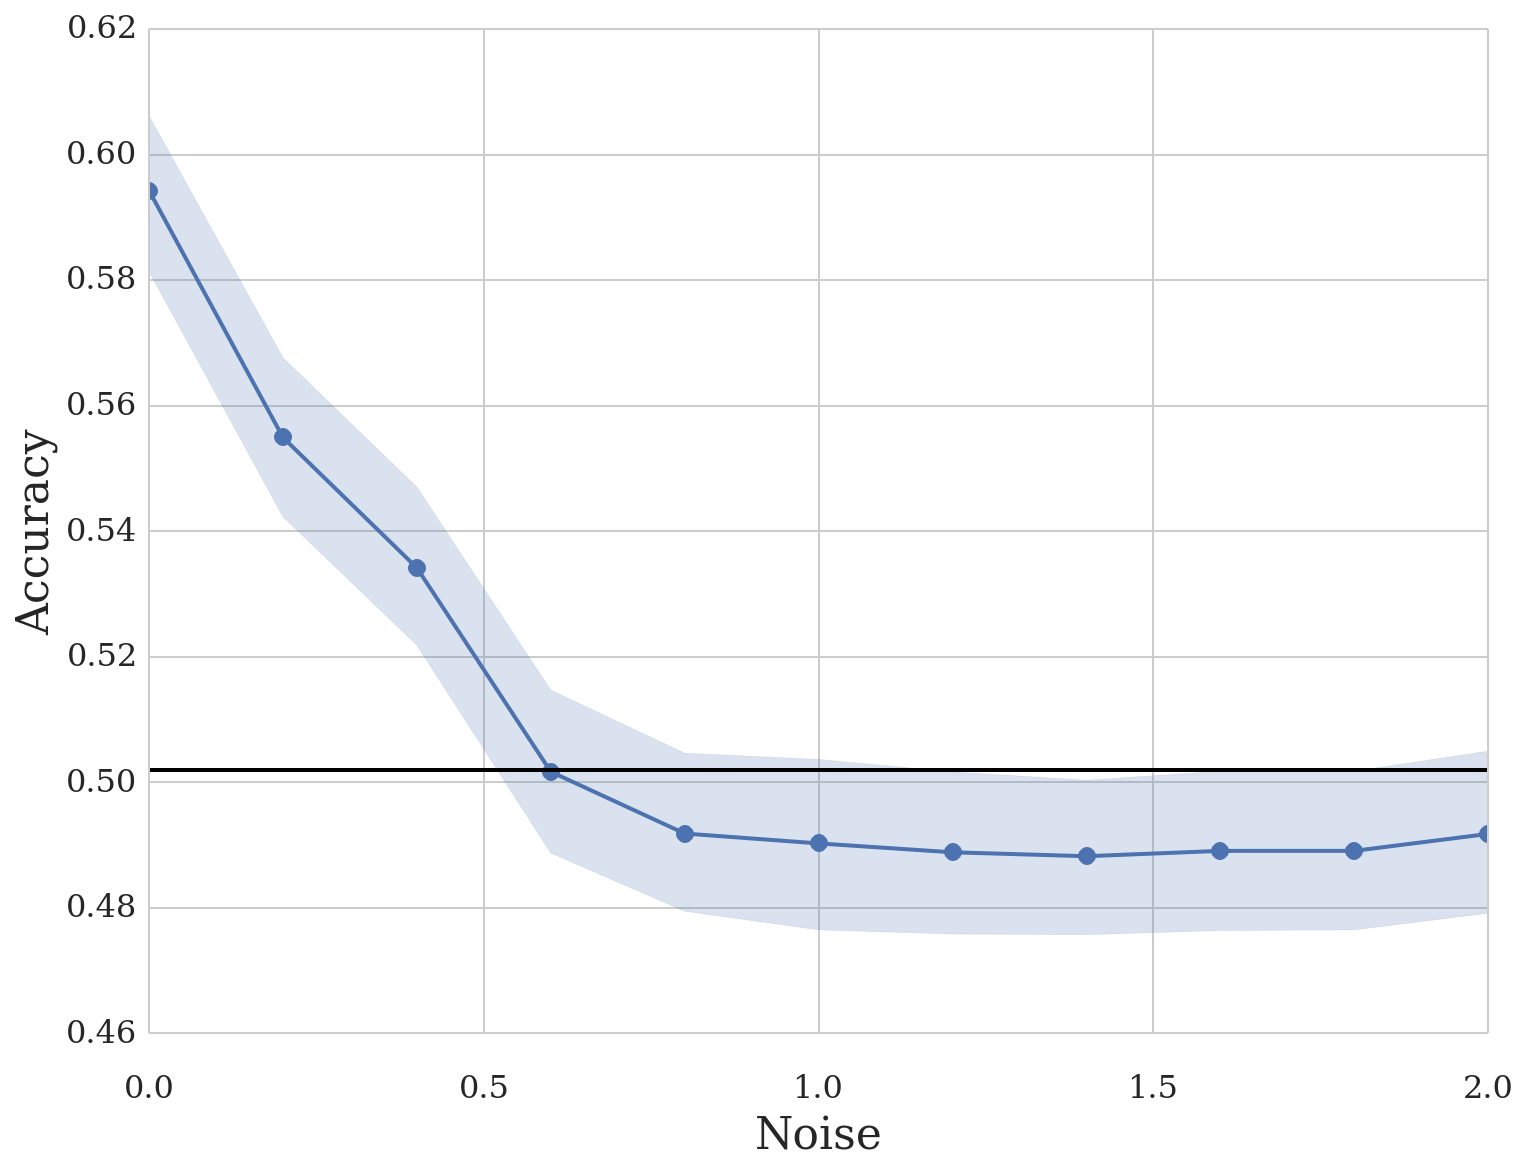

In [8]:
d['expansions__k'] = 30
df2 = plot(d).convert_objects(convert_numeric=True)
plt.savefig('plot-noise-gigaword-add-r2-k30.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

experiments are [403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413]
id 403 noise 0.00, acc 0.57, macrof1 0.48
id 404 noise 0.20, acc 0.54, macrof1 0.44
id 405 noise 0.40, acc 0.51, macrof1 0.38
id 406 noise 0.60, acc 0.50, macrof1 0.34
id 407 noise 0.80, acc 0.49, macrof1 0.33
id 408 noise 1.00, acc 0.49, macrof1 0.33
id 409 noise 1.20, acc 0.49, macrof1 0.33
id 410 noise 1.40, acc 0.49, macrof1 0.33
id 411 noise 1.60, acc 0.49, macrof1 0.33
id 412 noise 1.80, acc 0.49, macrof1 0.33
id 413 noise 2.00, acc 0.49, macrof1 0.33
Accuracy has 5500 values
folds has 5500 values
Noise has 5500 values
Calculating CI for exp 406
Calculating CI for exp 404
Calculating CI for exp 405
Calculating CI for exp 403
Calculating CI for exp 407
Calculating CI for exp 408
Calculating CI for exp 410
Calculating CI for exp 409
Calculating CI for exp 411
Calculating CI for exp 413
Calculating CI for exp 412
Running significance for (404, 405)
Running significance for (403, 404)
Running significance for (40

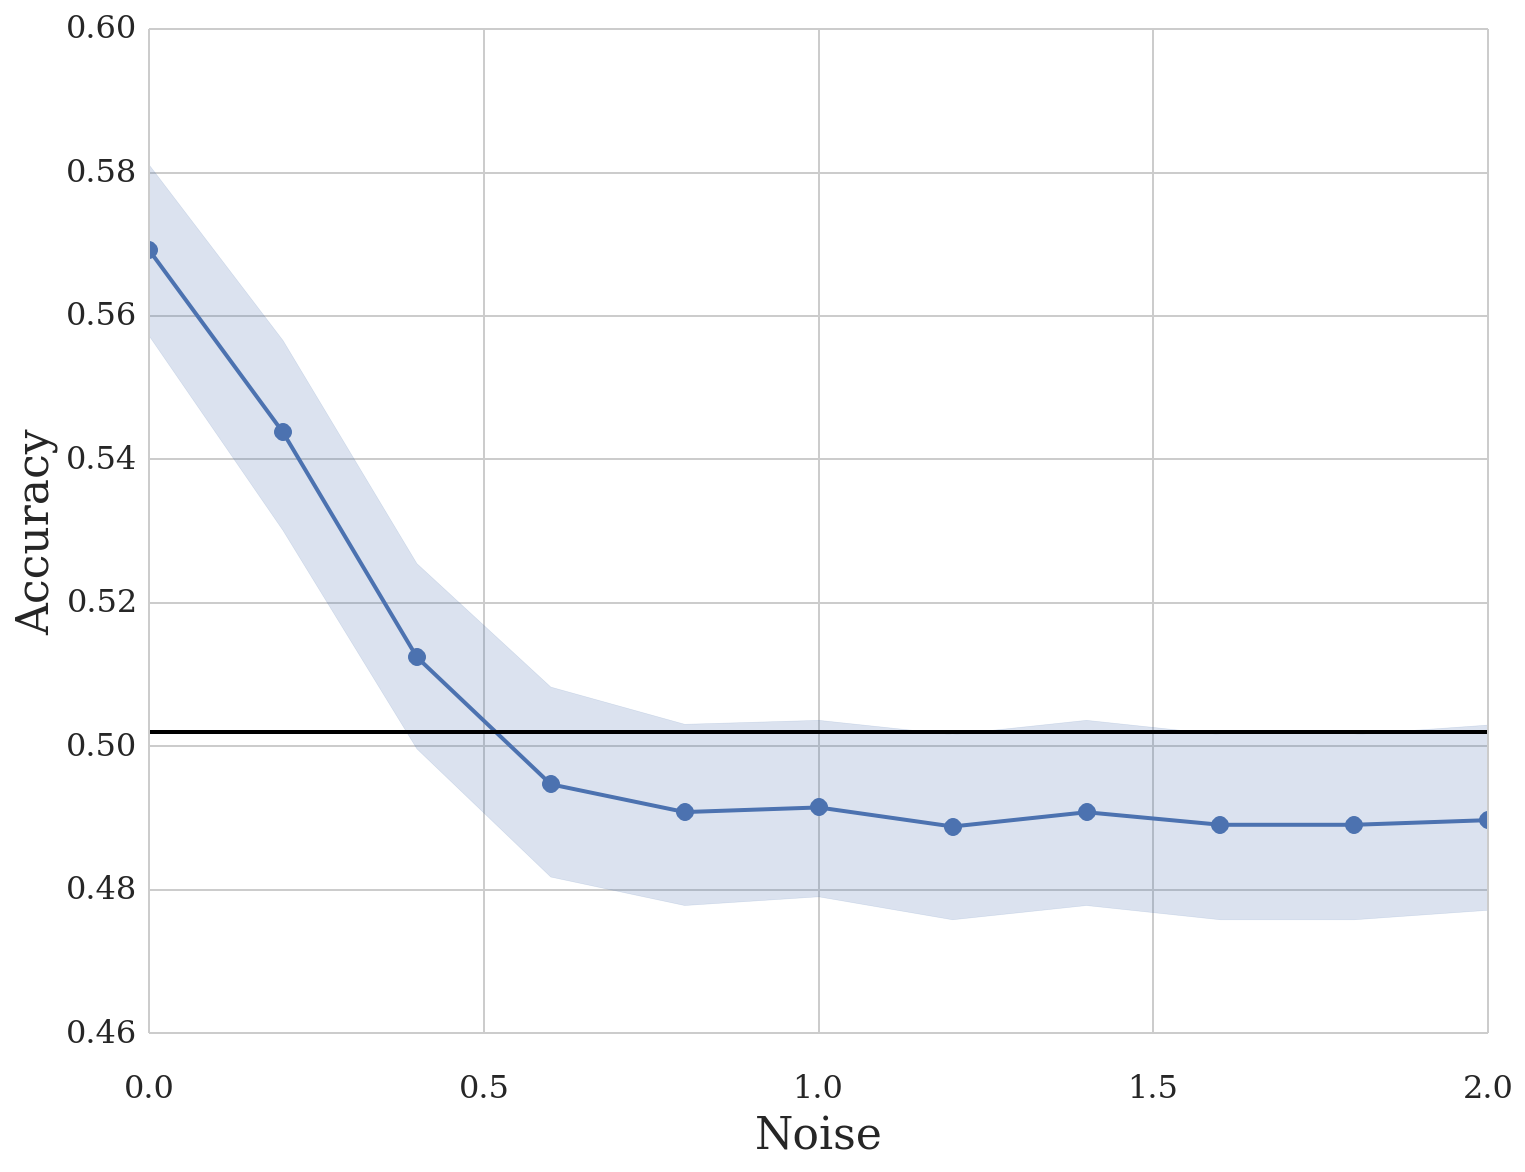

In [9]:
d['expansions__k'] = 60
df2 = plot(d).convert_objects(convert_numeric=True)
plt.savefig('plot-noise-gigaword-add-r2-k60.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)